<h2>Kinyrwanda HateSpeech Detection<h2>

- import libraries

In [26]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score,confusion_matrix,ConfusionMatrixDisplay

- import generated dataset

In [3]:
df = pd.read_csv('hate_speech_kinyarwanda_synthetic_mixed.csv')
df.head()

,text,label
0,Ukoresha amagambo nk’utunguwe,offensive
1,Uri inyamaswa itagira ubwenge,hate
2,Uri injiji,offensive
3,Ndashimira ubuyobozi bwacu bwiza butugeza ku n...,normal
4,Amahoro y’Imana abane namwe,normal


In [4]:
df.shape

(11000, 2)

- load Scraped dataset

In [5]:
df2 = pd.read_csv('final_dataset.tsv', sep='\t')
df2.rename(columns={'tweet' : 'text'}, inplace=True)
df2.head()

,text,label
0,Rutayomba warerewe muri @user n’umufasha we ba...,neutral
1,Maze ndumigwaga kokoooo😂😂😂😂😂😂 Caze kanigire gu...,negative
2,Ubushobozi bwawe ntibugaragarira mu ntege nye ...,positive
3,"@user Nese umuntu utareba arandika, gusa ahubw...",positive
4,Komeza wese imihigo nkuba y'inkubiri. Ishema r...,positive


<h3>Data Preprcessing <h3> <br>

- lowercase <br>
- remove punctuations <br>
- remove whitespaces <br>
- remove user handles '@', links and digits <br>
- remove stopwords

In [6]:
kinyarwanda_stopwords = set([
    "na", "ku", "mu", "ya", "y'", "n'", "bya", "cyane", "rwose",
    "kandi", "ubwo", "uko", "ntacyo", "ntukwiye", "ntacyo"
])


def preprocess_text(text):
    text = text.lower() #lowercase
    text = re.sub(r'@\w+|http\S+|\d+', '', text) #remove user handles, links, digits
    text = re.sub(r'[^\w\s]', '', text) #puncts
    text = re.sub(r'\s+', ' ', text).strip() #whitespaces
    
    words = text.split() #remove Kinyarwanda stopwords
    words = [word for word in words if word not in kinyarwanda_stopwords]
    
    return ' '.join(words)

- Apply preprocessing to both datasets

In [7]:
df['clean_text'] = df['text'].apply(preprocess_text)
df2['clean_text'] = df2['text'].apply(preprocess_text)

- Save cleaned versions

In [8]:
df.to_csv("kinyarwanda_hate_speech_preprocessed.csv", index=False)
df2.to_csv("kinyarwanda_hate_speech_preprocessed2.csv", index=False)

- Label Encoding

In [9]:
label_map_scraped = {
    "positive": "normal",
    "neutral": "normal",
    "negative": "offensive"
}

df2['label'] = df2['label'].map(label_map_scraped)
df2.head()

,text,label,clean_text
0,Rutayomba warerewe muri @user n’umufasha we ba...,normal,rutayomba warerewe muri numufasha we barwaye b...
1,Maze ndumigwaga kokoooo😂😂😂😂😂😂 Caze kanigire gu...,offensive,maze ndumigwaga kokoooo caze kanigire guhiga u...
2,Ubushobozi bwawe ntibugaragarira mu ntege nye ...,normal,ubushobozi bwawe ntibugaragarira ntege nye zun...
3,"@user Nese umuntu utareba arandika, gusa ahubw...",normal,nese umuntu utareba arandika gusa ahubwo uraby...
4,Komeza wese imihigo nkuba y'inkubiri. Ishema r...,normal,komeza wese imihigo nkuba yinkubiri ishema rya...


- Merge both Dataframes for training

In [10]:
df_merged = pd.concat([df2, df], ignore_index=True)

In [24]:
print("The merged DataFrame has: {} rows and {} columns".format(df_merged.shape[0], df_merged.shape[1]))

The merged DataFrame has: 16155 rows and 4 columns


In [25]:
df_merged['label'].value_counts()
print("Label classes distribution")
print(df_merged['label'].value_counts(normalize=True))

Label classes distribution
label
normal       0.447787
offensive    0.333333
hate         0.218880
Name: proportion, dtype: float64


In [13]:
le = LabelEncoder()
df_merged['label_encoded'] = le.fit_transform(df_merged['label'])

- Vectorization with Tfidf

In [14]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
x = vectorizer.fit_transform(df_merged['clean_text'])
y = df_merged['label_encoded']

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

<h3> Model Development<h3>

- Using Logistic regression with balanced wiehts

In [28]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

<h3> Model Evaluation<h3>

In [29]:
y_pred = lr.predict(x_test)
print("Logistic Regression")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Logistic Regression
              precision    recall  f1-score   support

        hate       1.00      0.96      0.98       743
      normal       0.83      0.93      0.88      1435
   offensive       0.89      0.77      0.83      1053

    accuracy                           0.89      3231
   macro avg       0.91      0.89      0.90      3231
weighted avg       0.89      0.89      0.89      3231



In [32]:
print("Evaluation Results")
print("Accuracy:", accuracy_score(y_test, y_pred).__round__(2))
print("Precision:", precision_score(y_test, y_pred, average='weighted').__round__(2))
print("Recall:", recall_score(y_test, y_pred, average='weighted').__round__(2))
print("F1-Score:", f1_score(y_test, y_pred, average='weighted').__round__(2))

Evaluation Results


Accuracy: 0.89
Precision: 0.89
Recall: 0.89
F1-Score: 0.89


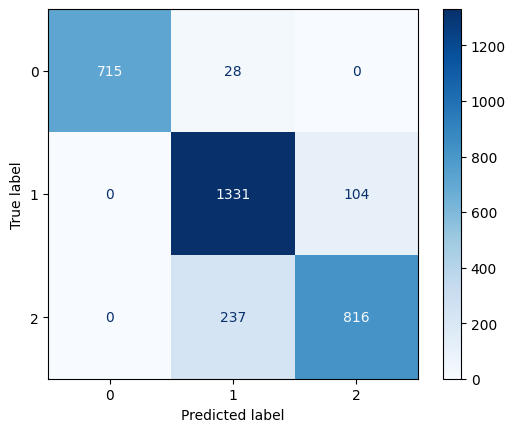

In [33]:
conf = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf).plot(cmap="Blues")

- Save model, encoder, and vectorizer for deployment

In [19]:
joblib.dump(lr, "lr_model.pkl")
joblib.dump(vectorizer, "tfidf.pkl")
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

- Test samples

In [20]:
samples = [
    "Uyu system irakora fine, ariko needs some improvements ku speed yayo.",
    "Ntukemere ibyo badakora, those people have bad intentions.",
    "Ndi happy na service yawe, keep up the good work!",
    "Iyo message ni offensive, ntabwo byakagombye gusohoka.",
    "Ibi ni hate speech, tugomba kubirwanya buri gihe.",
    "Please stop gukoresha imvugo mbi, birabangamira benshi.",
    "Twese dukwiriye kubana mu mahoro no respect, no matter the language.",
    "Ese uri gukora update kuri app? It’s very slow these days.",
    "Ibitekerezo byawe birimo negativity, try to be more positive.",
    "Umutwe w’akazi uyu week warakomeye, but I managed to finish everything."
]

In [21]:
for tweet in samples:
    clean = preprocess_text(tweet)
    vec = vectorizer.transform([clean])
    pred = lr.predict(vec)[0]
    label = le.inverse_transform([pred])[0]
    print(f"Tweet: {tweet}\nPredicted label: {label}\n")

Tweet: Uyu system irakora fine, ariko needs some improvements ku speed yayo.
Predicted label: normal

Tweet: Ntukemere ibyo badakora, those people have bad intentions.
Predicted label: normal

Tweet: Ndi happy na service yawe, keep up the good work!
Predicted label: normal

Tweet: Iyo message ni offensive, ntabwo byakagombye gusohoka.
Predicted label: offensive

Tweet: Ibi ni hate speech, tugomba kubirwanya buri gihe.
Predicted label: normal

Tweet: Please stop gukoresha imvugo mbi, birabangamira benshi.
Predicted label: normal

Tweet: Twese dukwiriye kubana mu mahoro no respect, no matter the language.
Predicted label: normal

Tweet: Ese uri gukora update kuri app? It’s very slow these days.
Predicted label: normal

Tweet: Ibitekerezo byawe birimo negativity, try to be more positive.
Predicted label: normal

Tweet: Umutwe w’akazi uyu week warakomeye, but I managed to finish everything.
Predicted label: offensive

